# Census Data Analysis of USA - Polyzos Fotios

This project aims at exploratory analysis of US data, with the main objective of identifying trends and related patterns among the distribution of income, in correlation with given demographic data. The dataset contains necessary information on age, employment, education level, marital status, place of birth, hours worked, gender, race, state, and of course, income.

## Importing data and modifying them appropriately.

In [3]:
import pandas as pandas
import matplotlib.pyplot as pyplot
import numpy as numpy
from scipy.stats import chi2_contingency, ttest_ind, pearsonr
import seaborn as sb

attribute_values = pandas.read_csv("data/Attribute_Values.csv")
census_data = pandas.read_csv("data/Census_Data.csv")

Then we create a dictionary from Attribute_Values to group the data and then perform the requested conversion of CoW, education, marital etc.

In [5]:
census_data_dtfr = census_data.copy()

diction = {}
for attribute in attribute_values["Attribute"].unique():
    subset = attribute_values[attribute_values["Attribute"] == attribute]
    zipped = zip(subset["NumValue"], subset["Value"])
    mapping = dict(zipped)
    diction[attribute] = {int(k): v for k, v in mapping.items()}

columns_to_replace = ["marital", "PoB", "sex", "race", "state"]

for col in columns_to_replace:
    census_data_dtfr[col] = census_data_dtfr[col].astype("Int64")

for col in columns_to_replace:
    if col in diction:
        census_data_dtfr[col] = census_data_dtfr[col].map(diction[col])

#education
census_data_dtfr["education"] = census_data_dtfr["education"].astype("Int64")

if "education" in diction:
    census_data_dtfr["education_desc"] = census_data_dtfr["education"].map(diction["education"])

def categorize_education(num_value):
    if num_value <= 15:
        return "no diploma"
    if num_value in [16, 17]:
        return "high-school"
    if num_value in [18, 19]:
        return "post-high-school"
    return diction["education"][num_value] 

census_data_dtfr["edc_ctg"] = census_data_dtfr["education"].apply(categorize_education)

# marital
if census_data_dtfr["marital"].dtype in ["float64", "int64"]:
    census_data_dtfr["marital"] = census_data_dtfr["marital"].astype("Int64")
    if "marital" in diction:
        census_data_dtfr["marital"] = census_data_dtfr["marital"].map(diction["marital"])

#PoB
def categorize_pob(value):
    if isinstance(value, (int, float)):
        return "US" if (1 <= value and value <= 99 and value != 60) else "Not US"
    elif isinstance(value, str) and "/" in value:
        return "US"
    return "Not US"

census_data_dtfr["PoB_category"] = census_data_dtfr["PoB"].apply(categorize_pob)

print(census_data_dtfr.head())

    age  CoW  education                              marital  occupation  \
0  18.0  1.0         18  Never married or under 15 years old      4720.0   
1  53.0  5.0         17  Never married or under 15 years old      3605.0   
2  41.0  1.0         16  Never married or under 15 years old      7330.0   
3  18.0  6.0         18  Never married or under 15 years old      2722.0   
4  21.0  5.0         19  Never married or under 15 years old      3870.0   

          PoB  hours     sex                    race       state   income  \
0  Georgia/GA   21.0  Female  Black/African American  Alabama/AL   1600.0   
1  Indiana/IN   40.0    Male                   White  Alabama/AL  10000.0   
2  Alabama/AL   40.0    Male                   White  Alabama/AL  24000.0   
3  Alabama/AL    2.0  Female                   White  Alabama/AL    180.0   
4  Florida/FL   50.0    Male                   White  Alabama/AL  29000.0   

                                 education_desc           edc_ctg PoB_category  

## Histogram of income with 100 bins

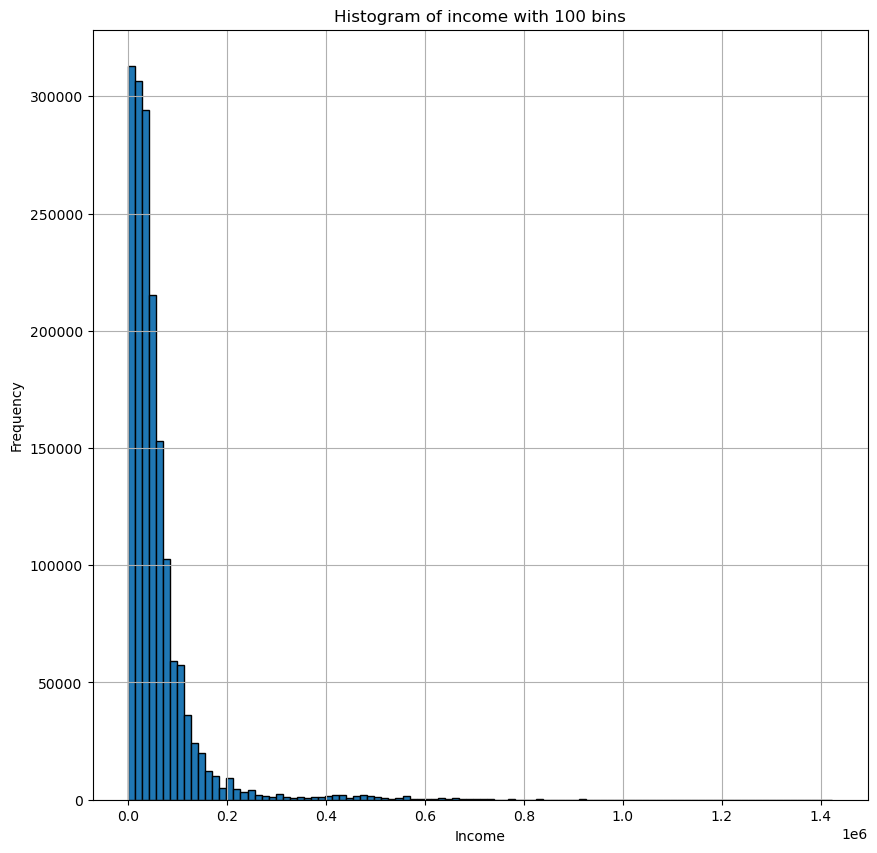

In [9]:
census_data_dtfr["income"].plot.hist(bins=100, edgecolor="black", figsize=(10, 10))
pyplot.title("Histogram of income with 100 bins")
pyplot.xlabel("Income")
pyplot.ylabel("Frequency")
pyplot.grid(True)
pyplot.show()

We note the strong asymmetry of the distribution, with the vast majority of incomes being low and a few high. Almost all of the values are concentrated in the range between 0 and 200,000 with values higher than this being rare. Although high incomes are rare, they can affect values like the average.

## New log_income column with the logarithm of the income

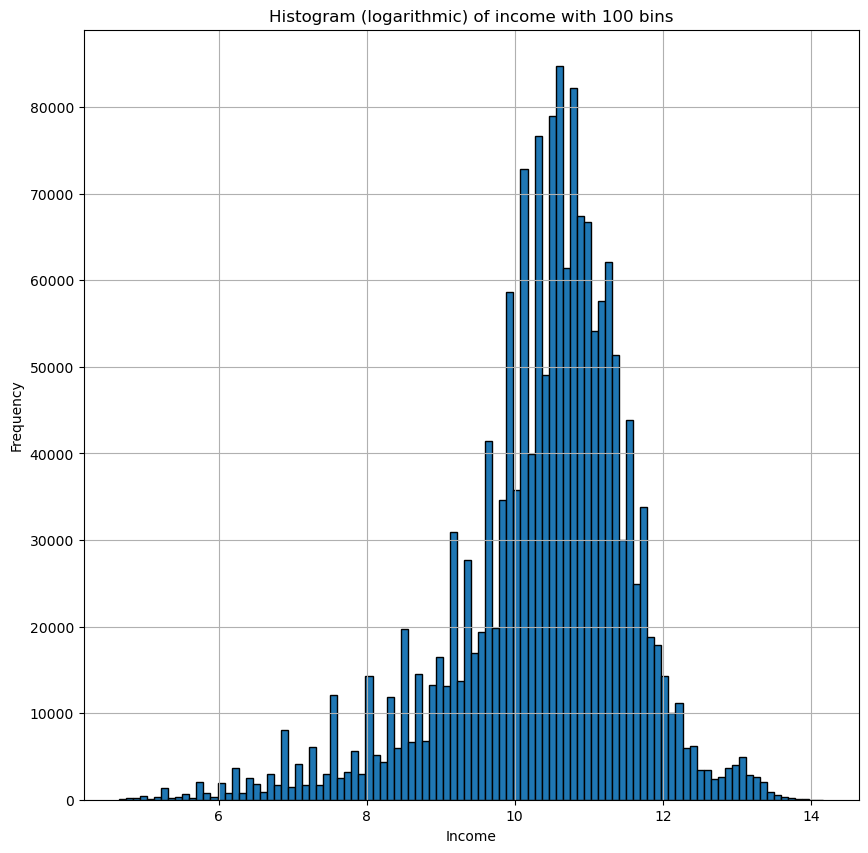

In [15]:
census_data_dtfr['log_income'] = numpy.log(census_data_dtfr['income'] + 1)
census_data_dtfr["log_income"].plot.hist(bins=100, edgecolor="black", figsize=(10, 10))
pyplot.title("Histogram (logarithmic) of income with 100 bins")
pyplot.xlabel("Income")
pyplot.ylabel("Frequency")
pyplot.grid(True)
pyplot.show()

The distribution now shows symmetry and so we understand that the logarithmic transformation has reduced the effect of outliers. There is a concentration of values from about 20,000 to 60,000. So the distribution becomes more symmetrical and more like a normal distribution.

## Cumulative Frequency Vector

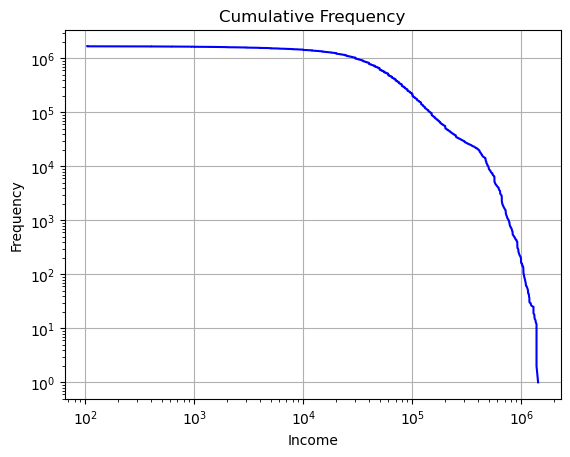

In [17]:
sorted = numpy.sort(census_data_dtfr['income'])
cumul_frq = len(sorted) - numpy.arange(len(sorted))

pyplot.plot(sorted, cumul_frq, label="Cumulative Frequency", color='blue')
pyplot.title("Cumulative Frequency")
pyplot.xscale('log')
pyplot.yscale('log')
pyplot.xlabel("Income")
pyplot.ylabel("Frequency")

pyplot.grid(True)
pyplot.show()

The majority of all records show low income, as the cumulative frequency remains high even for lower income values. The number of individuals with incomes between 100,000 and 1,000,000 shows a sharp decline. Also based on the logarithmic scale, we see the strong dispersion of the data. Strong inequality in the distribution of income.

## Zipf plot

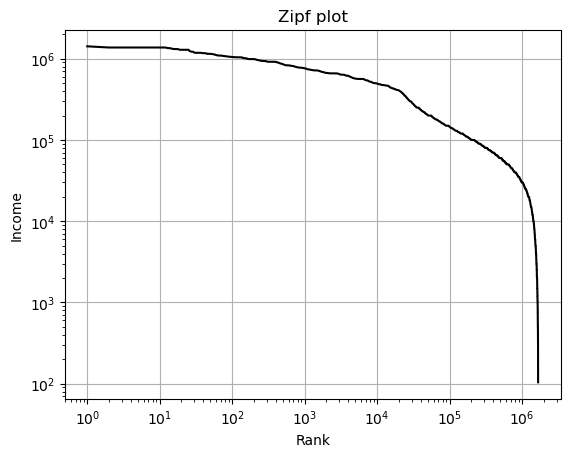

In [21]:
sorted_min = numpy.sort(census_data_dtfr['income'])[::-1]

ranks = numpy.arange(1, len(sorted_min) + 1)

pyplot.plot(ranks, sorted_min, label="Zipf plot", color='black')
pyplot.title("Zipf plot")
pyplot.xscale('log')
pyplot.yscale('log')
pyplot.xlabel("Rank")
pyplot.ylabel("Income")

pyplot.grid(True)
pyplot.show()

Strong asymmetric distribution in the top ranks, which makes us realize that there is a very small percentage of people with high incomes. Through the steep drop, we realize that low incomes are much more common. Through Zipf plot on an algorithmic scale, we see the "rarity" of high incomes.

## Correlation between gender, race and ancestry (PoB) and job category.

++++++++++++++++++++
Test for sex and CoW:
Chi2 = 38793.540, p-value = 0.0000, DOF = 7
++++++++++++++++++++


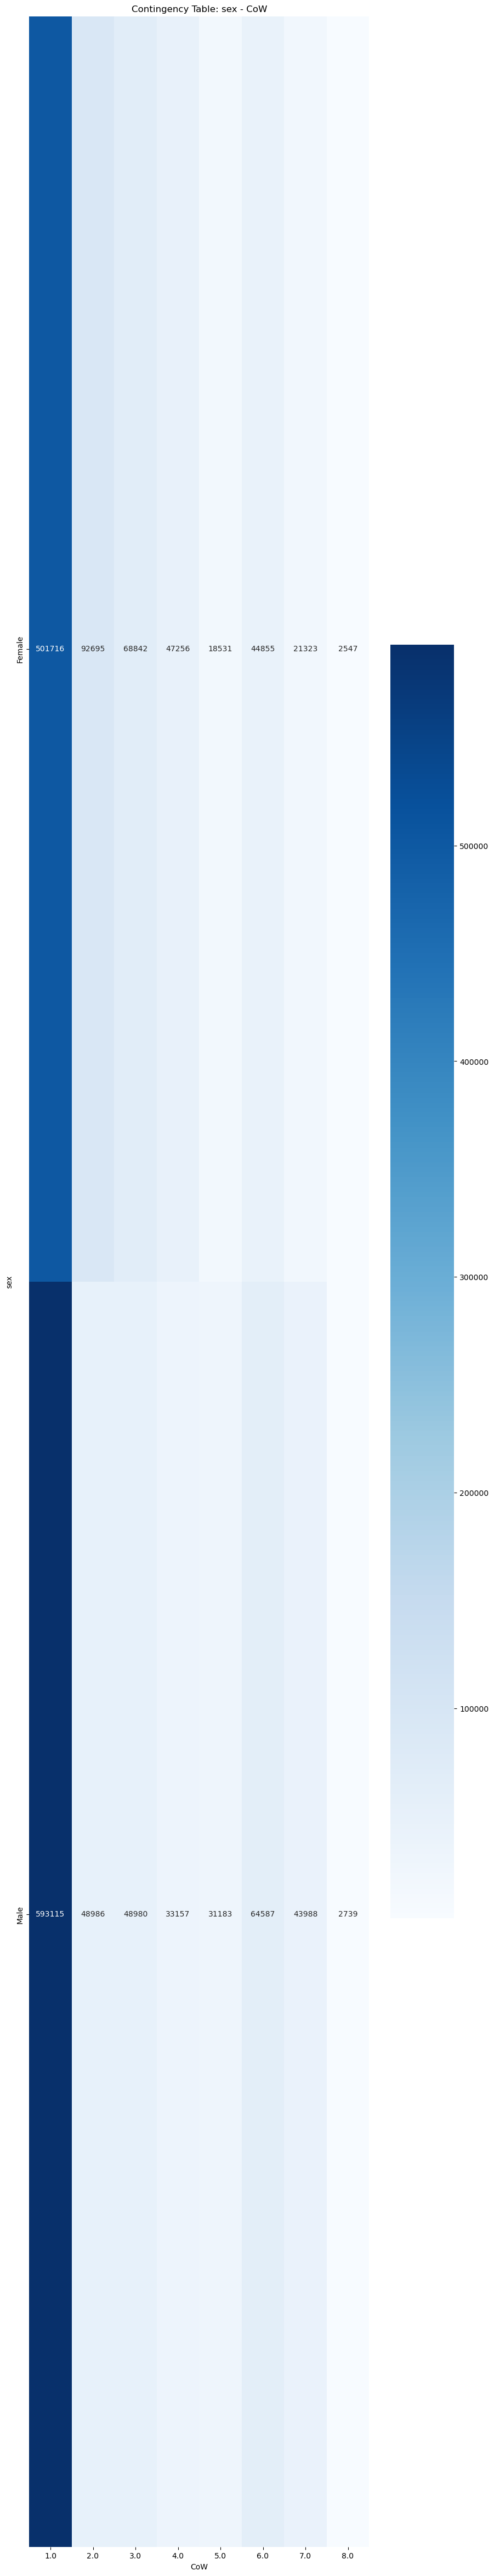

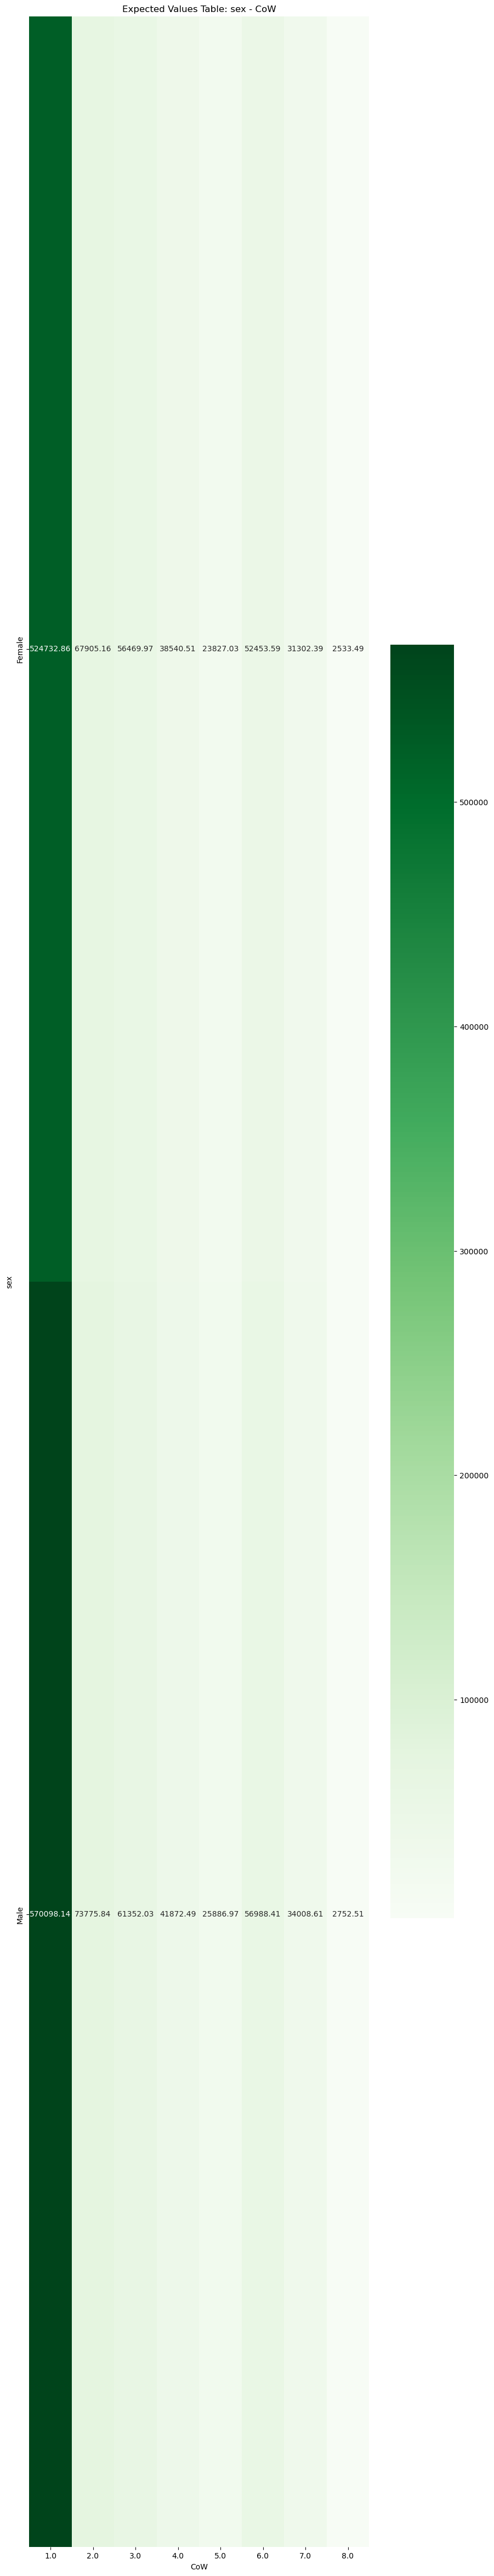

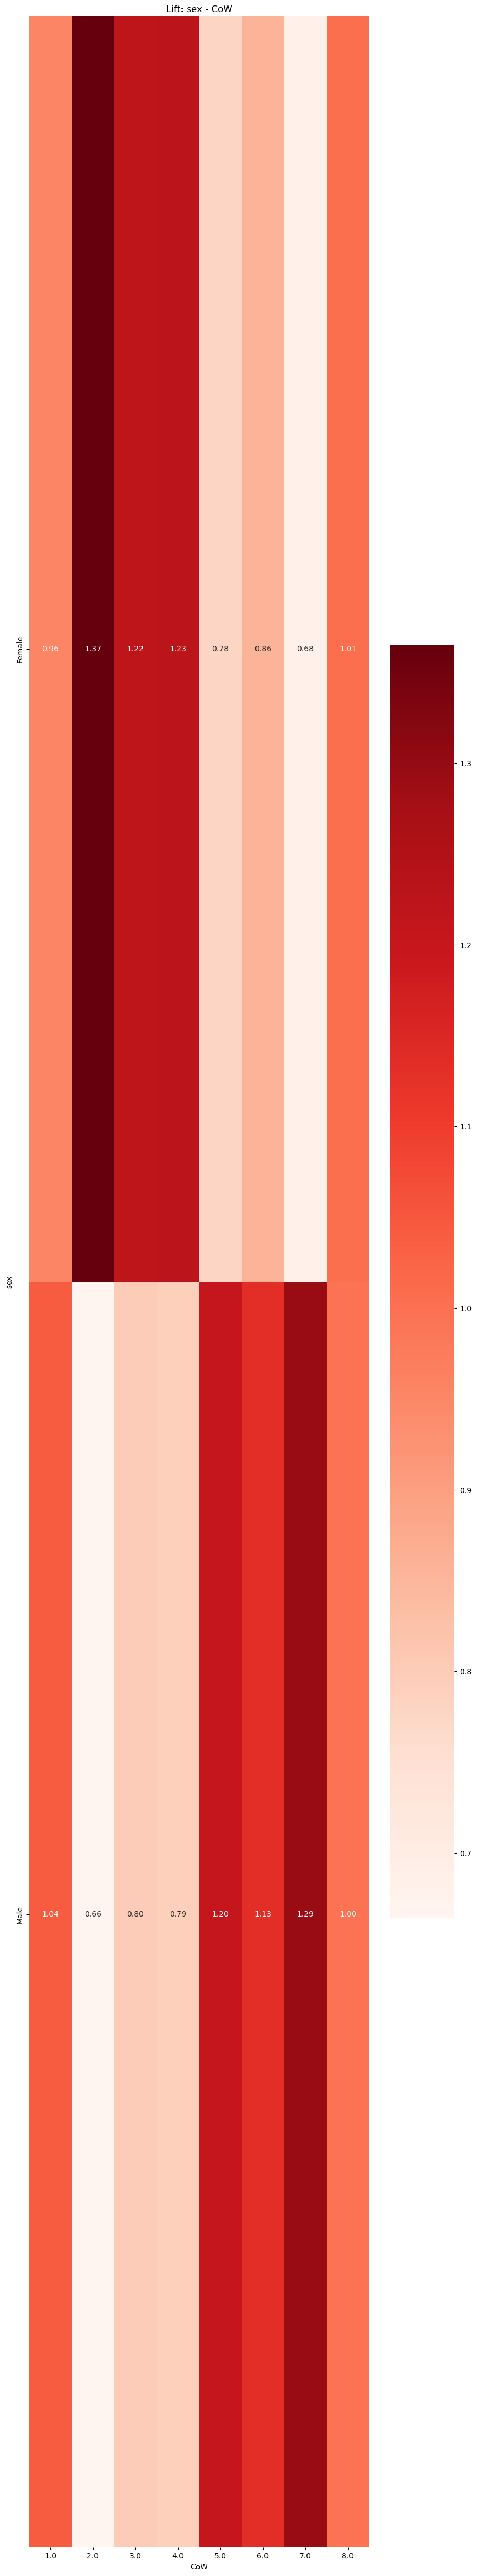

CoW  sex   
2.0  Female    1.365066
7.0  Male      1.293437
4.0  Female    1.226138
3.0  Female    1.219090
5.0  Male      1.204583
6.0  Male      1.133336
1.0  Male      1.040374
8.0  Female    1.005335
     Male      0.995090
1.0  Female    0.956136
dtype: float64
++++++++++++++++++++
Test for race and CoW:
Chi2 = 16901.178, p-value = 0.0000, DOF = 56
++++++++++++++++++++


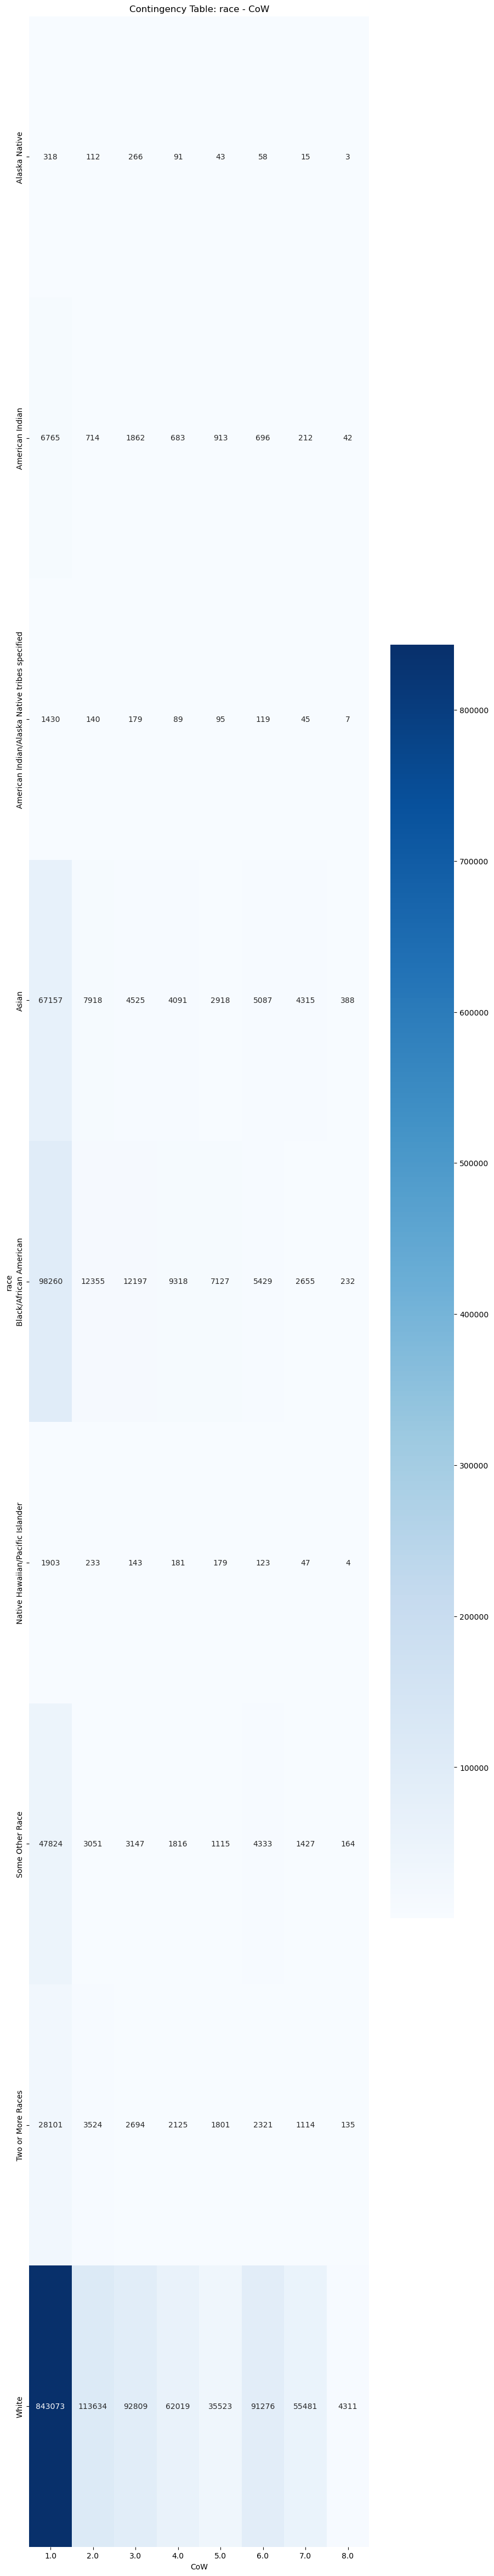

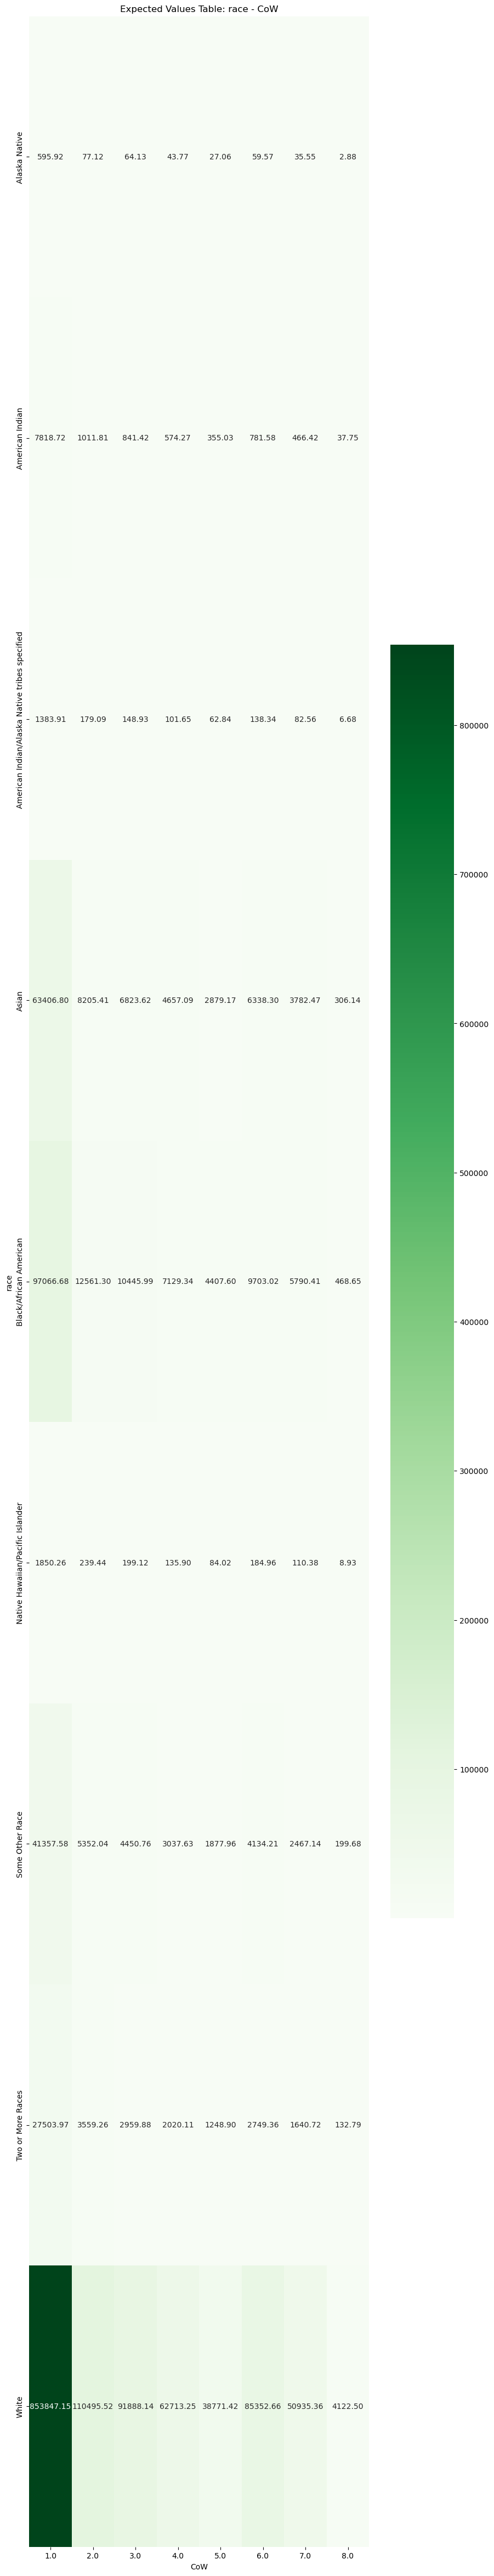

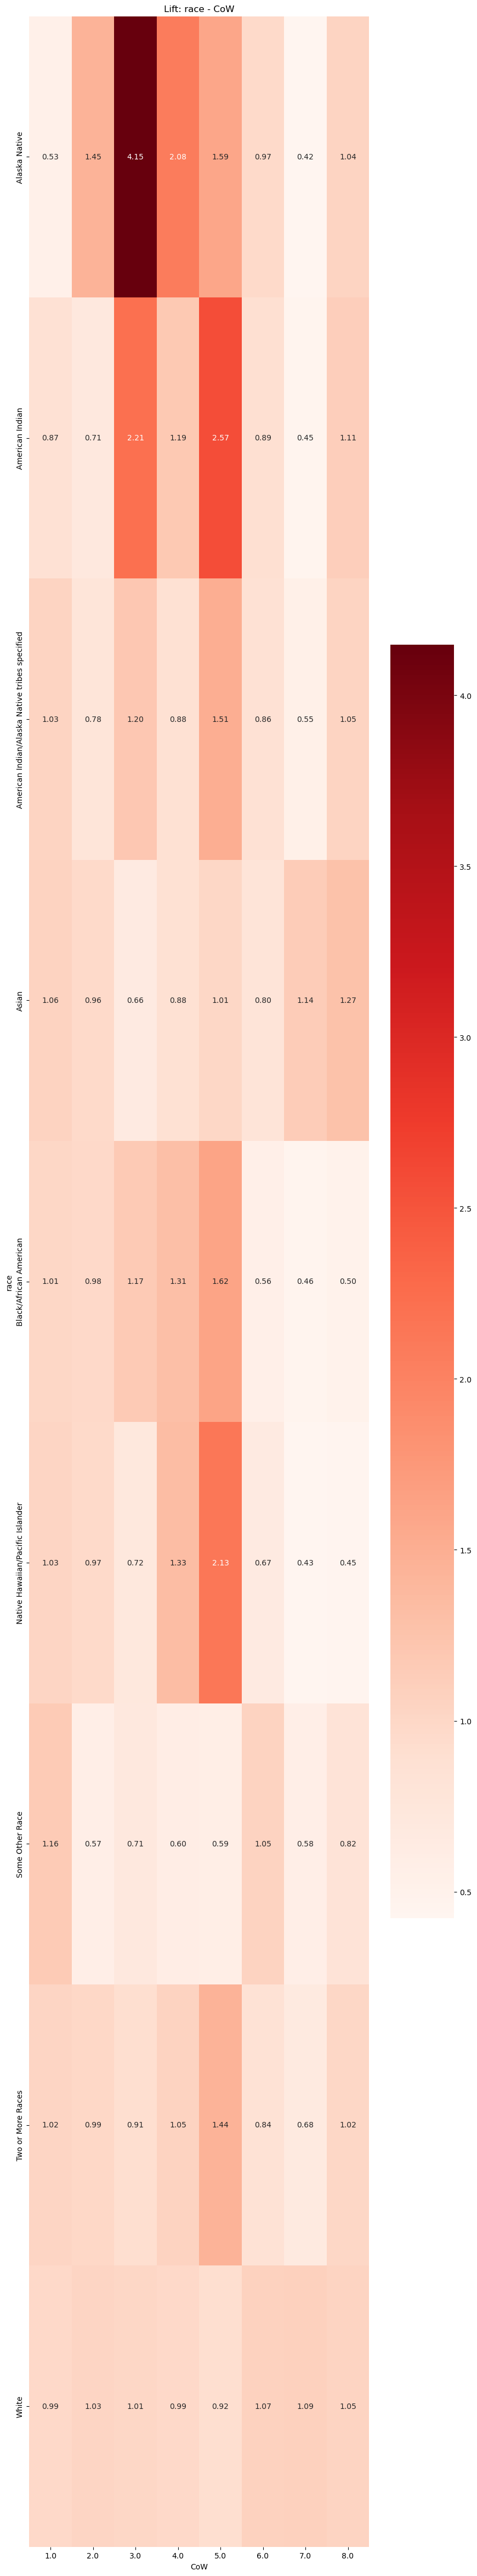

CoW  race                                          
3.0  Alaska Native                                     4.147734
5.0  American Indian                                   2.571601
3.0  American Indian                                   2.212915
5.0  Native Hawaiian/Pacific Islander                  2.130534
4.0  Alaska Native                                     2.079078
5.0  Black/African American                            1.616981
     Alaska Native                                     1.589078
     American Indian/Alaska Native tribes specified    1.511760
2.0  Alaska Native                                     1.452319
5.0  Two or More Races                                 1.442071
dtype: float64
++++++++++++++++++++
Test for PoB and CoW:
Chi2 = 37436.642, p-value = 0.0000, DOF = 1561
++++++++++++++++++++


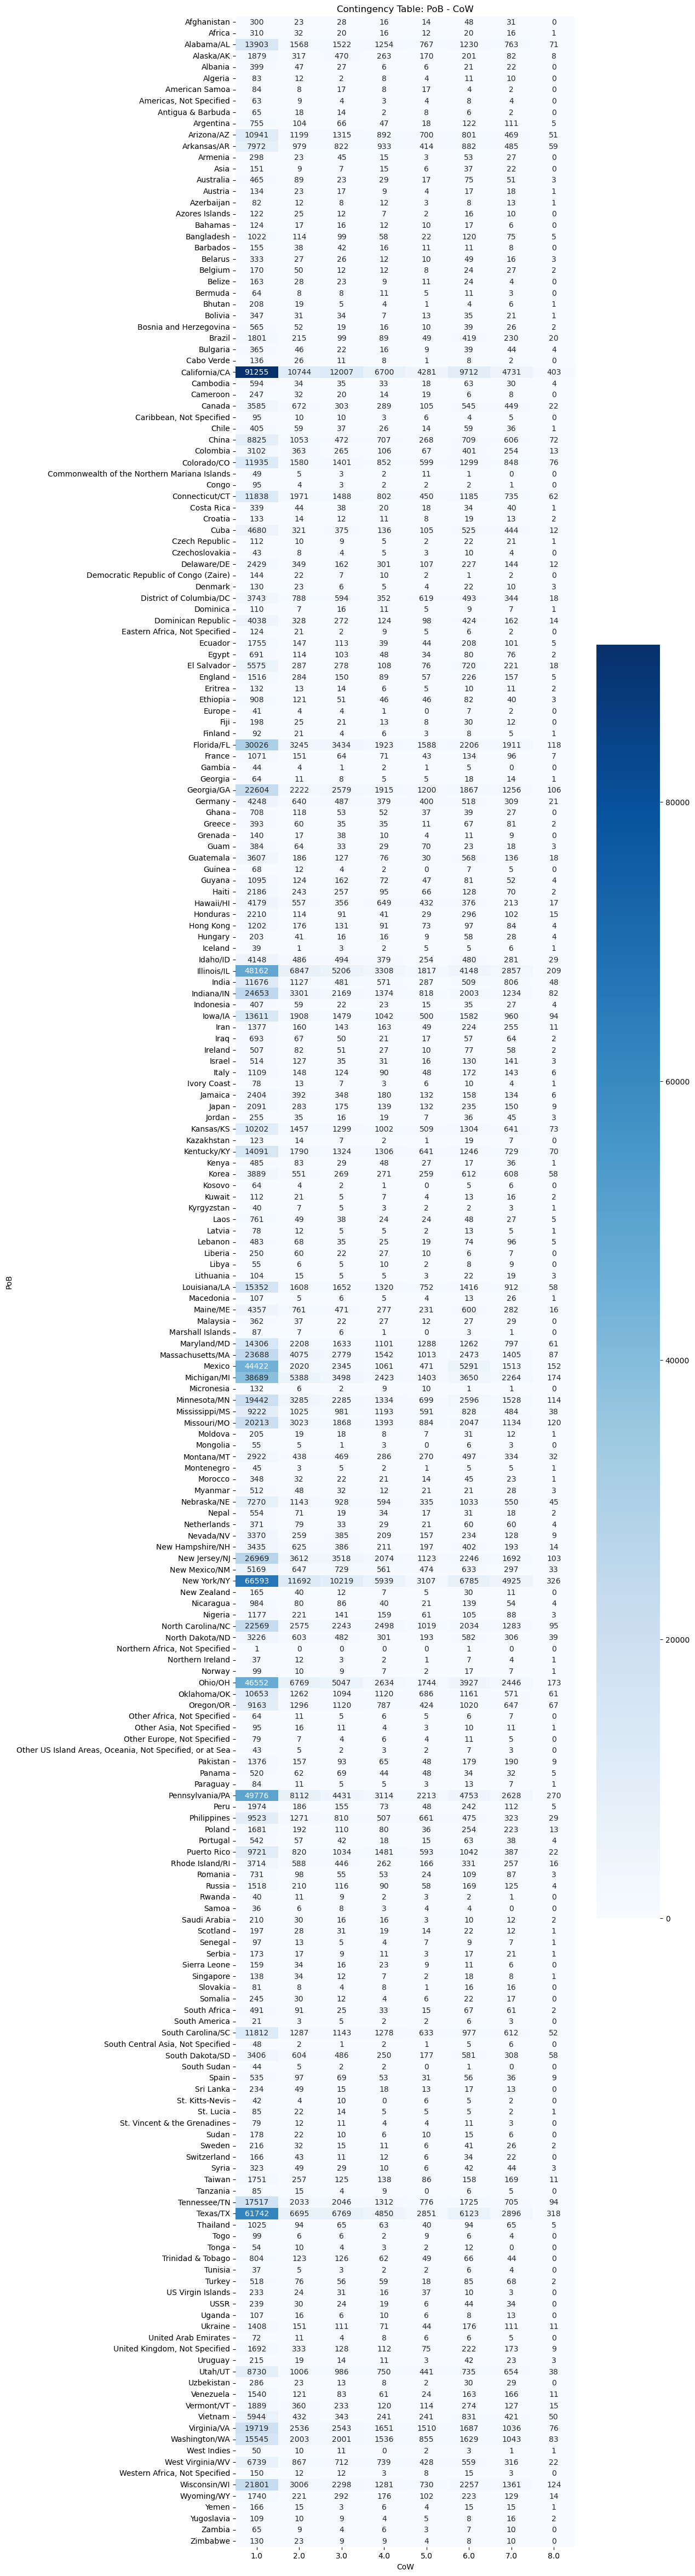

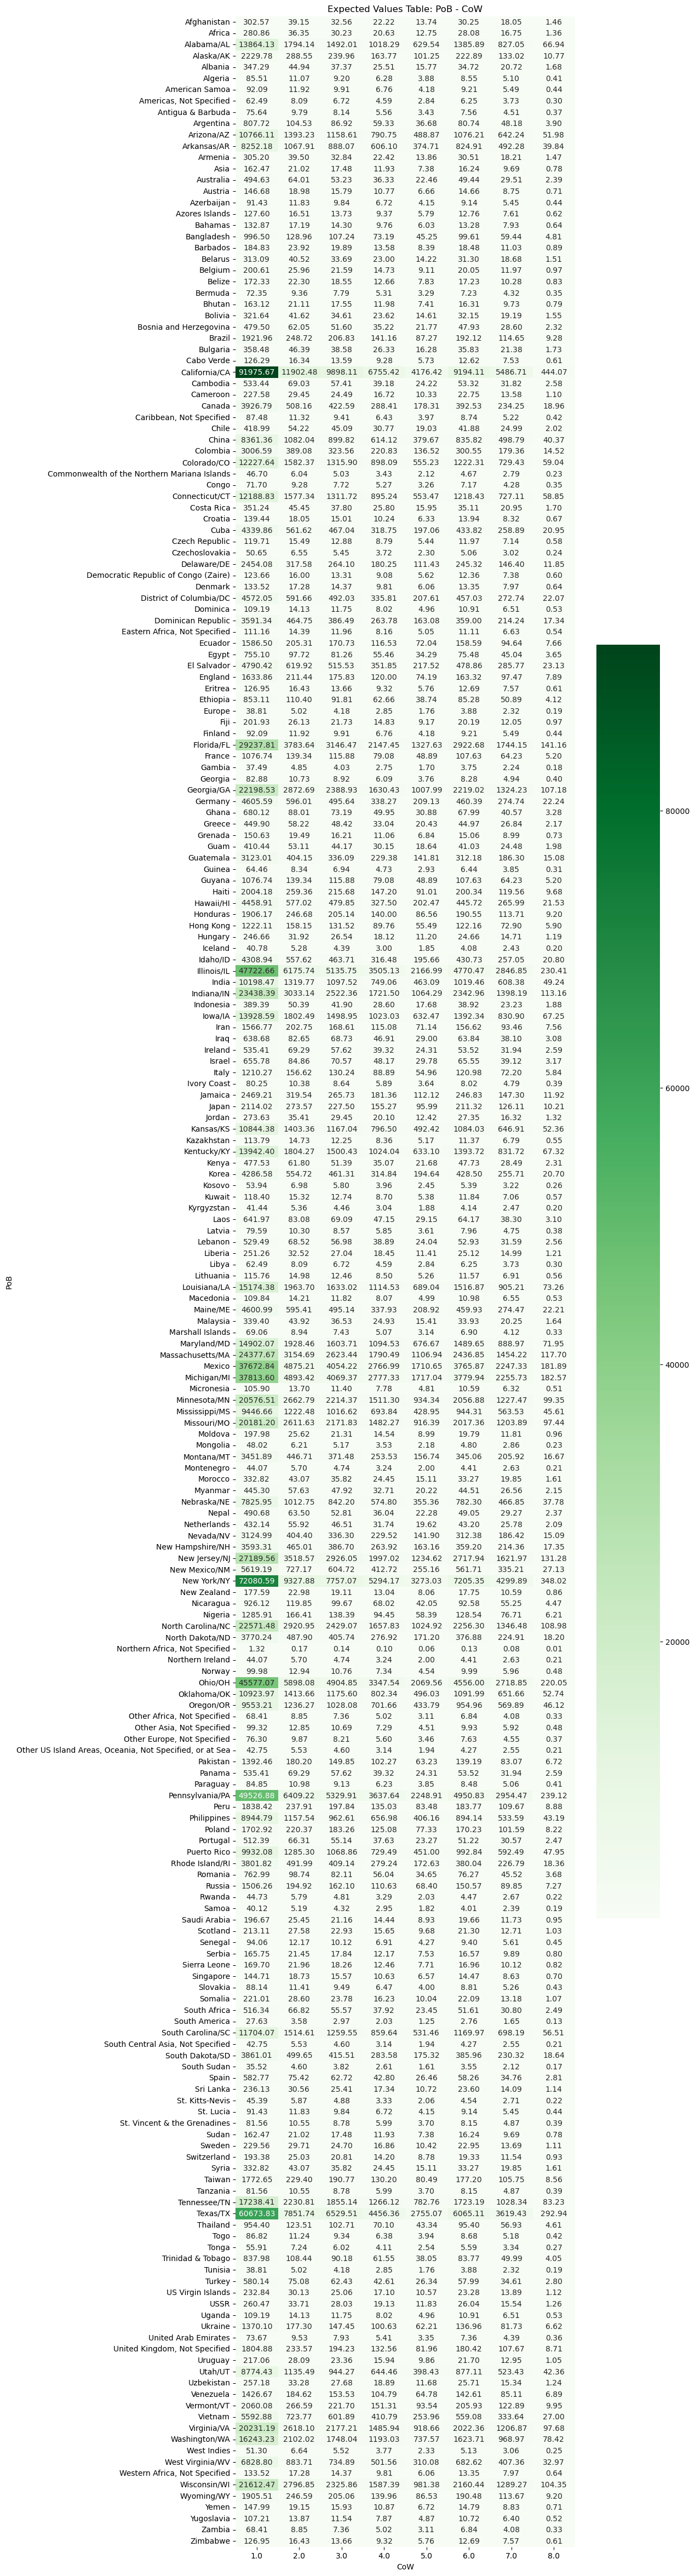

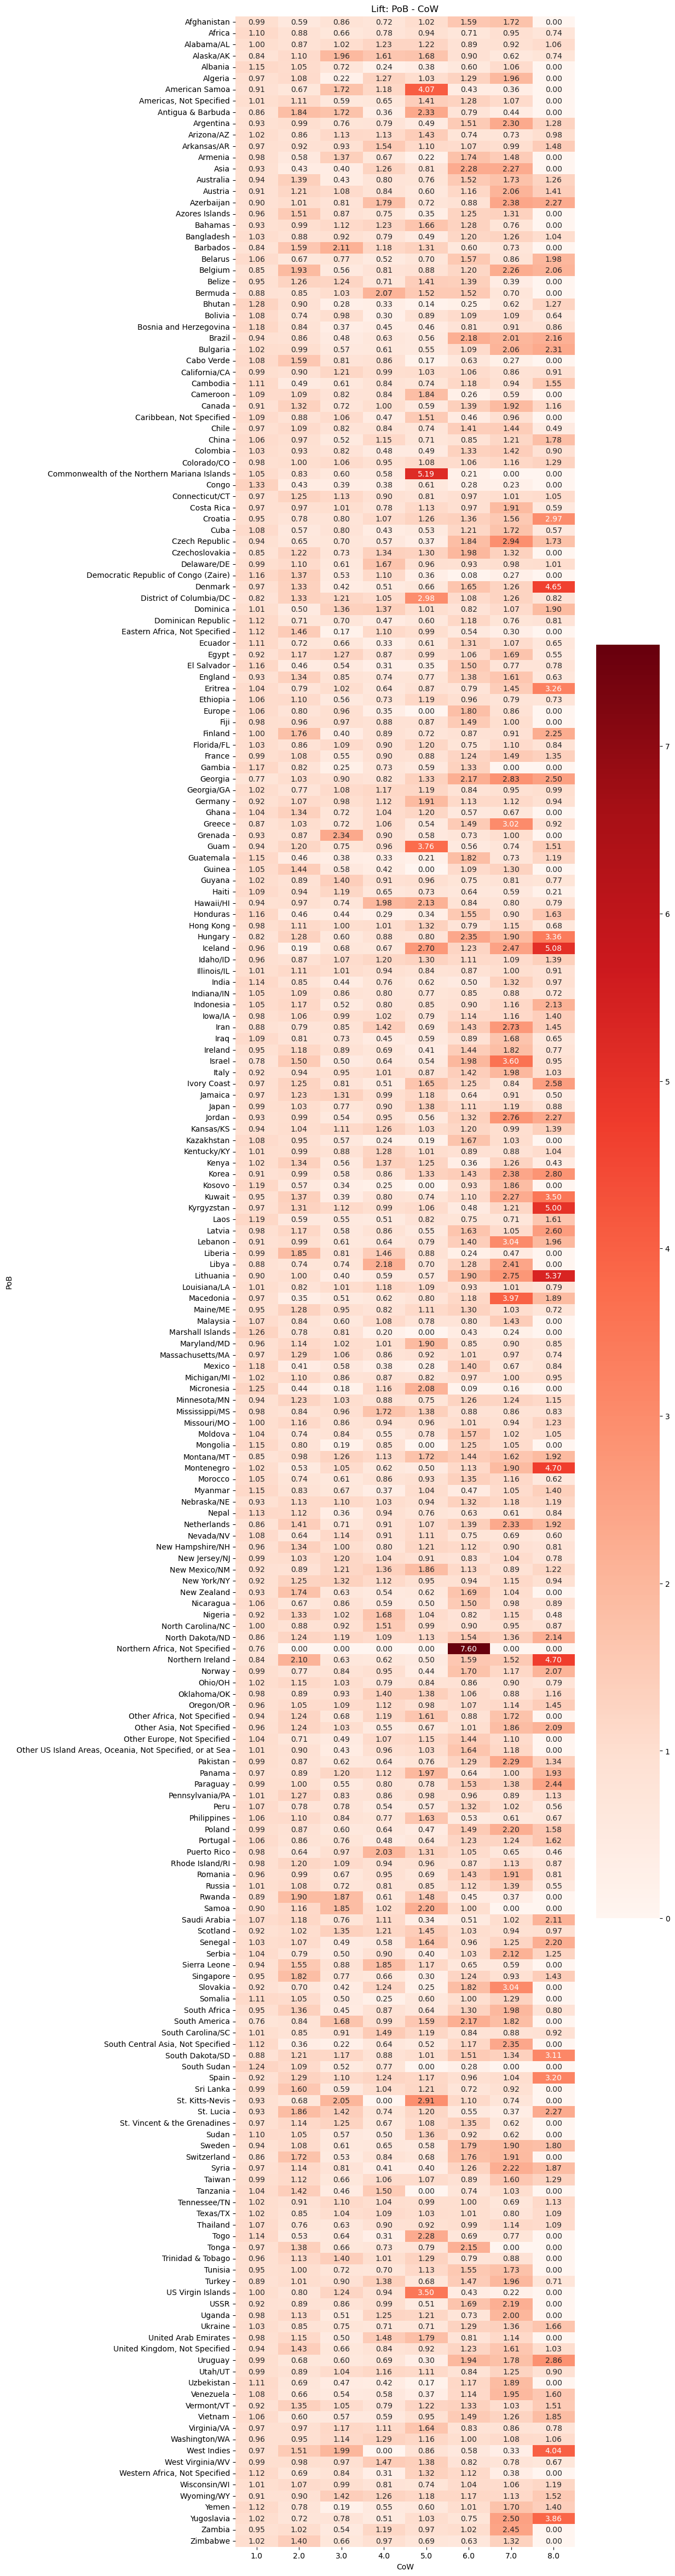

CoW  PoB                                         
6.0  Northern Africa, Not Specified                  7.604485
8.0  Lithuania                                       5.367416
5.0  Commonwealth of the Northern Mariana Islands    5.187277
8.0  Iceland                                         5.078845
     Kyrgyzstan                                      4.998228
     Northern Ireland                                4.699827
     Montenegro                                      4.699827
     Denmark                                         4.653523
5.0  American Samoa                                  4.065612
8.0  West Indies                                     4.037031
dtype: float64


In [25]:
pairs = [("sex", "CoW"), ("race", "CoW"), ("PoB", "CoW")]

res = {}

for i, j in pairs:
    con_tables = pandas.crosstab(census_data_dtfr[i], census_data_dtfr[j])

    chi, p , d, expected = chi2_contingency(con_tables)

    res[(i, j)] = {"chi": chi, "p-value": p, "d": d, "expected": expected}

    print ("+"*20)
    print(f"Test for {i} and {j}:")
    print(f"Chi2 = {chi:.3f}, p-value = {p:.4f}, DOF = {d}")
    print ("+"*20)

    pyplot.figure(figsize=(10, 60))
    sb.heatmap(con_tables, annot=True, fmt="d", cmap="Blues", cbar=True)
    pyplot.title(f"Contingency Table: {i} - {j}")
    pyplot.xlabel(j)
    pyplot.ylabel(i)
    pyplot.show()

    #expected
    pyplot.figure(figsize=(10, 60))
    sb.heatmap(pandas.DataFrame(expected, index=con_tables.index, columns=con_tables.columns),annot=True, fmt=".2f", cmap="Greens", cbar=True)
    pyplot.title(f"Expected Values Table: {i} - {j}")
    pyplot.xlabel(j)
    pyplot.ylabel(i)
    pyplot.show()

    lift = con_tables / expected
    pyplot.figure(figsize=(10, 60))
    sb.heatmap(lift, annot=True, fmt=".2f", cmap="Reds", cbar=True)
    pyplot.title(f"Lift: {i} - {j}")
    pyplot.xlabel(j)
    pyplot.ylabel(i)
    pyplot.show()

    print(lift.unstack().sort_values(ascending=False).head(10))

We note that the p-values are extremely low (< 0.001). Which means that there is a statistically significant correlation between the categories. So we realize that gender, race and ancestry influence occupation! The large sample size enhances the power of the test and makes them quite sensitive. We also realize that there is social inequality. The "Whites" category is the most populous across all occupational sectors with a significant presence of Asian & Black/African American as well. Much lower are American Indian and Alaska Native, suggesting possible inequality in some jobs. Also, without a doubt we see that US-born individuals are in the majority in each job sector. With a p-value < 0.001 suggesting that ancestry influences job position.

We can also observe individual pairs of values with a large Lift, such as the following:

We see that men are more likely to be self-employed while women are much more likely to work in administrative government positions. So there is a disparity in the sector but not to an extreme degree.

Additionally, Alaska Native and American Indian people show a very high probability of being government employees, while Whites have an increased probability of being self-employed. At the same time, Asians are also highly likely to be in the No Pay category. 

We also find that individuals from Lithuania have a much higher probability of being in the No Pay category, with individuals from Iceland and Kyrgyztan following in the relative list. Also strikingly high is the lift of Self-Employed in Northern Africa. Clear evidence that origin plays a crucial role in occupational status.

## Difference in average income values between genders, races, or origins.

We will examine whether the above attributes have any correlation with income. Our goal is to examine whether there is a statistically significant difference in the mean values of income between genders, races, or origins.

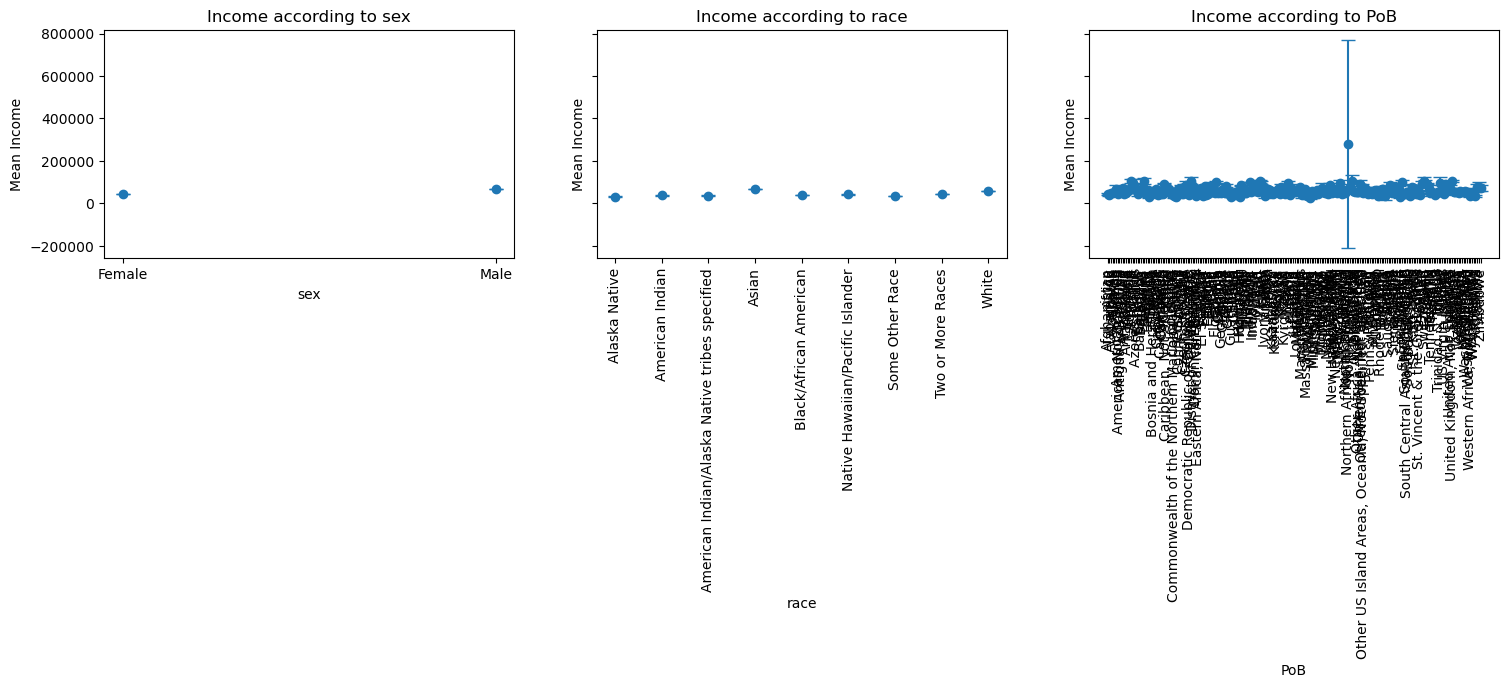

Male vs Female: t-test = 206.8814, p-value = 0.0000
White vs Non-White: t-test = 88.6466, p-value = 0.0000


In [31]:
def calc_means(dt, grp, col):
    data = dt.groupby(grp)[col].agg(["mean", "count", "std"])
    s = data["std"] / data["count"]**0.5
    data["upp"] = data["mean"] + 1.96 * s
    data["low"] = data["mean"] - 1.96 * s
    data.reset_index(inplace=True)
    return data[["mean", "upp", "low", grp]]


attr = ["sex", "race", "PoB"]
res={}
for i in attr:
    res[i] = calc_means(census_data_dtfr, i, "income")

fig, axes = pyplot.subplots(1, 3, figsize=(18, 6), sharey=True)

for i, att in enumerate(attr):
    data = calc_means(census_data_dtfr, att, "income")
    axes[i].errorbar(data[att], data["mean"], 
                     yerr=(data["upp"] - data["mean"]),
                     fmt="o", linestyle="none", capsize=5)
    axes[i].set_title(f"Income according to {att}")
    axes[i].set_ylabel("Mean Income")
    axes[i].set_xlabel(att)
    if att == "race" or att == "PoB":
        axes[i].tick_params(axis='x', rotation=90)

pyplot.subplots_adjust(bottom=0.5)
pyplot.show()

male_inc = census_data_dtfr[census_data_dtfr['sex'] == 'Male']['income']
female_inc = census_data_dtfr[census_data_dtfr['sex'] == 'Female']['income']
t_stat_sex, p_val_sex = ttest_ind(male_inc, female_inc)
print(f"Male vs Female: t-test = {t_stat_sex:.4f}, p-value = {p_val_sex:.4f}")

white_inc = census_data_dtfr[census_data_dtfr['race'] == 'White']['income']
non_wh_inc = census_data_dtfr[census_data_dtfr['race'] != 'White']['income']
t_stat_race, p_val_race = ttest_ind(white_inc, non_wh_inc)
print(f"White vs Non-White: t-test = {t_stat_race:.4f}, p-value = {p_val_race:.4f}")

us_inc = census_data_dtfr[census_data_dtfr['PoB'] == 'US']['income']
not_us_inc = census_data_dtfr[census_data_dtfr['PoB'] == 'Not US']['income']
t_stat_pob, p_val_pob = ttest_ind(us_inc, not_us_inc)


It can be seen that men's incomes are higher than women's. With the p-value being extremely small (<0.001), a significant statistic, we conclude that this difference in income is not random.

We also note that Whites, have the highest median income, suggesting that ancestry is very likely to play a role in an individual's economic status.

# Scatter Plots

We will examine whether there is a correlation between income and some attributes that take continuous values, with scatter plots of education, age and hours with income, and log_income for the state of California.

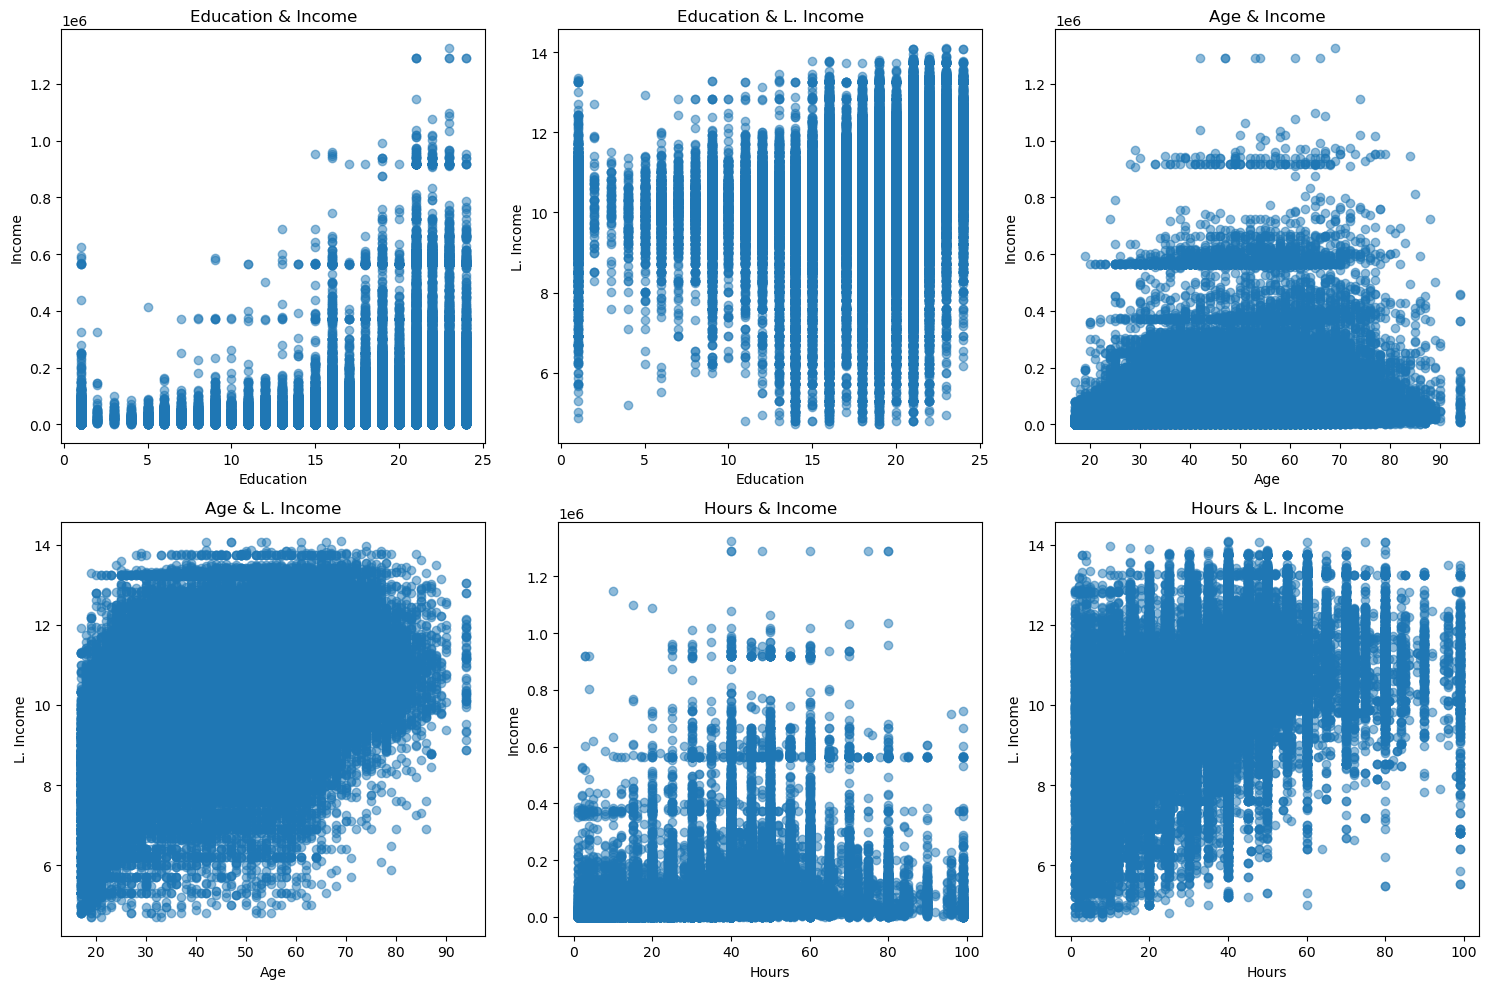

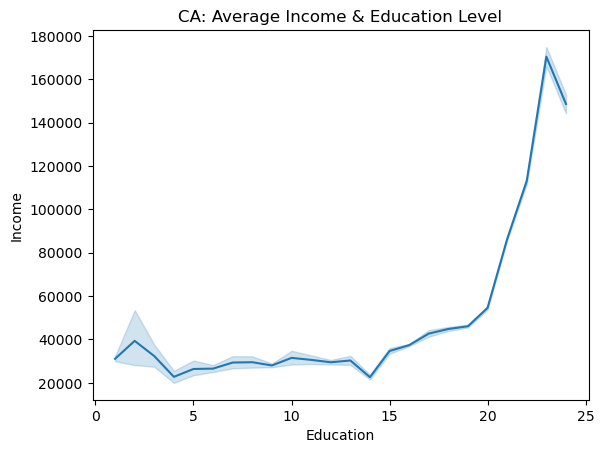

In [37]:
ca_data = census_data_dtfr[census_data_dtfr["state"] == "California/CA"]

fig, axes = pyplot.subplots(2, 3, figsize=(15, 10))

axes[0, 0].scatter(ca_data["education"], ca_data["income"], alpha = 0.5)
axes[0, 0].set_title('Education & Income')
axes[0, 0].set_xlabel('Education')
axes[0, 0].set_ylabel('Income')

axes[0, 1].scatter(ca_data["education"], ca_data["log_income"], alpha = 0.5)
axes[0, 1].set_title('Education & L. Income')
axes[0, 1].set_xlabel('Education')
axes[0, 1].set_ylabel('L. Income')

axes[0, 2].scatter(ca_data["age"], ca_data["income"], alpha = 0.5)
axes[0, 2].set_title('Age & Income')
axes[0, 2].set_xlabel('Age')
axes[0, 2].set_ylabel('Income')

axes[1, 0].scatter(ca_data["age"], ca_data["log_income"], alpha = 0.5)
axes[1, 0].set_title('Age & L. Income')
axes[1, 0].set_xlabel('Age')
axes[1, 0].set_ylabel('L. Income')

axes[1, 1].scatter(ca_data["hours"], ca_data["income"], alpha = 0.5)
axes[1, 1].set_title('Hours & Income')
axes[1, 1].set_xlabel('Hours')
axes[1, 1].set_ylabel('Income')

axes[1, 2].scatter(ca_data["hours"], ca_data["log_income"], alpha = 0.5)
axes[1, 2].set_title('Hours & L. Income')
axes[1, 2].set_xlabel('Hours')
axes[1, 2].set_ylabel('L. Income')

pyplot.tight_layout()
pyplot.show()

vars = ["education", "age", "hours"]
res={}
for var in vars:
    r_inc, p_inc = pearsonr(ca_data[var], ca_data['income'])
    r_inc_log, p_inc_log = pearsonr(ca_data[var], ca_data['log_income'])
    res = {
        "income":{"r":r_inc, "p":p_inc},
        "income_log":{"r":r_inc_log, "p":p_inc_log}
    }

sb.lineplot(x="education", y="income", data=ca_data, errorbar=('ci', 95))
pyplot.title("CA: Average Income & Education Level")
pyplot.xlabel("Education")
pyplot.ylabel("Income")
pyplot.show()

We generally observe that individuals with more years of education have higher average income and there is also a significant dispersion in the low values of education, indicating that it is not an exclusive determinant of income. With log income, we see that although education is important, it does not have a vertical effect on income.

Also, income increases until the 50s and then we observe some stabilization.

In addition, we see that there are individuals who, although they have many hours of work, do not have the corresponding income. And with the logarithm also this observation becomes more obvious.

In the last graph for California, USA we see that as the level of education increases, so does the income. After 15 years, there is an obvious upward trend. At the same time, in the shaded area we also see the 95% confidence interval with more predictable data at higher levels of education.